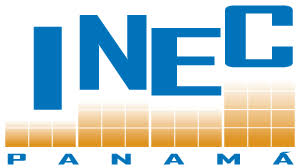

# Construcción de base de datos

Esta libreria construye las bases de datos necesarias para realizar las estimaciones en los siguientes pasos. Integra las distintas frecuencias de las observaciones dentro de una base única.


# Librerias importadas

Se importan las librerías necesarias para realizar el manejo de base de datos y/o proyecciones del modelos.

- pykalman: Librería de filtro de kalman en python.
- pandas: Manejo de bases de datos
- datetime: Manejo de fechas
- numpy: Manejo de matrices
- matploblib.pyplot: Gráficos
- os: Manejo de rutas
- numdifftools: Libreria para calculo de gradientes y derivadas
- statsmodels.tsa.arima_model: Modelos de series de tiempo
- statsmodels.tsa.api: Gráfico de autocorrelaciones
- seaborn: Gráficos adicionales

In [1]:
import pykalman as kalman
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import os

import numdifftools

from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

import seaborn as sns

# Rutas para guardar inputs/outputs

In [2]:
#Ruta de donde se lee el excel bd_inputs
rutaOrigen = 'inputs/'
rutaDestino = 'resultados/'
rutaModelos = 'model_interpol'


# Construcción de base de datos

Se crea la función BasedeDatos, que será usada en los siguientes programas para consolidar la información.

Esta función crea la base de datos consolidada tomando como input un excel con bases de datos mensuales/trimestrales/anuales, creando las variables en:

- Niveles (Sufijo: Nivel)
- Acumulado 12 meses (Sufijo: 12Meses)
- Logaritmos (Sufijo: Logs)
- Variación Mensual (Sufijo: VariacionMensual)
- Variación Anual de la información mensual (Sufijo: Mensual_VariacionAnual)
- Variación Anual de los acumulados a 12 meses (Sufijo: 12Meses_VariacionAnual)
- Variación Trimestral (Sufijo: VariacionTrimestral)
- Variación Anual de la información trimestral (Sufijo: Trimestre_VariacionAnual)
- Variación Anual de la información anual (Sufijo: VariacionAnual)

In [3]:
def BasedeDatos(Base):
    
    #####################################################################################
    #Importando base de datos mensual
    
    bd_mensual = pd.read_excel(Base, header= 2, sheet_name='Mensual')
    bd_mensual.mes = bd_mensual.mes.map(lambda x : pd.to_datetime(x, format = '%Y'))
    bd_mensual = bd_mensual.rename(columns = {'mes':'per'})
    bd_mensual  = bd_mensual.set_index('per')
    
    bd_mensual_t = pd.DataFrame(index=bd_mensual.index)
    for x in bd_mensual.columns:
        bd_mensual_t[x + '_Nivel'] = bd_mensual[x]
        bd_mensual_t[x + '_12Meses'] = bd_mensual[x].rolling(12).sum()
        bd_mensual_t[x + '_Logs'] = np.log(bd_mensual[x])
        bd_mensual_t[x + '_Trimestre'] = bd_mensual[x].rolling(3).mean()
        bd_mensual_t[x + '_Trimestre_VariacionAnual'] = bd_mensual_t[x + '_Trimestre']/bd_mensual_t[x + '_Trimestre'].shift(12) - 1 
        bd_mensual_t[x + '_VariacionMensual'] = bd_mensual[x]/bd_mensual[x].shift() - 1
        bd_mensual_t[x + '_Mensual_VariacionAnual'] = bd_mensual[x]/bd_mensual[x].shift(12) - 1
        bd_mensual_t[x + '_12Meses_VariacionAnual'] = bd_mensual_t[x + '_12Meses']/bd_mensual_t[x + '_12Meses'].shift(12) - 1 

    #####################################################################################
     #Base Trimestral
    
    bd_trimestral = pd.read_excel(Base, header= 2, sheet_name='Trimestral')
    bd_trimestral  = bd_trimestral.set_index('per')

    bd_trimestral_t = pd.DataFrame(index=bd_trimestral.index)
    for x in bd_trimestral.columns:
        bd_trimestral_t[x + '_Nivel'] = bd_trimestral[x]
        bd_trimestral_t[x + '_12Meses'] = bd_trimestral[x].rolling(4).sum()
        bd_trimestral_t[x + '_Logs'] = np.log(bd_trimestral[x])
        bd_trimestral_t[x + '_VariacionTrimestral'] = bd_trimestral[x]/bd_trimestral[x].shift() - 1
        bd_trimestral_t[x + '_Trimestre_VariacionAnual'] = bd_trimestral[x]/bd_trimestral[x].shift(4) - 1
        bd_trimestral_t[x + '_12Meses_VariacionAnual'] = bd_trimestral_t[x + '_12Meses']/bd_trimestral_t[x + '_12Meses'].shift(4) - 1 
        
    #####################################################################################
    #Base Anual
        
    bd_anual = pd.read_excel(Base, header= 2, sheet_name='Anual')
    bd_anual.per = bd_anual.per.map(lambda x : pd.to_datetime('12' + str(x), format = '%m%Y'))
    bd_anual  = bd_anual.set_index('per')
    
    bd_anual_t = pd.DataFrame(index=bd_anual.index)
    for x in bd_anual.columns:
        bd_anual_t[x + '_Nivel'] = bd_anual[x]
        bd_anual_t[x + '_Logs'] = np.log(bd_anual[x])
        bd_anual_t[x + '_VariacionAnual'] = bd_anual[x]/bd_anual[x].shift() - 1
        
    bd_all = bd_mensual_t.join(bd_trimestral_t).join(bd_anual_t)
    
    return bd_mensual_t, bd_trimestral_t, bd_anual_t, bd_all

In [4]:
bd_mensual_t,bd_trimestral_t,bd_anual_t,bd_all = BasedeDatos(rutaOrigen + 'bd_Panama.xlsx')

# Base de Datos Mensual

###### Estadísticos Descriptivos

In [5]:
display(bd_mensual_t[[x for x in bd_mensual_t if 'Nivel' in x]].describe())
display(bd_mensual_t[[x for x in bd_mensual_t if 'Logs' in x]].describe())
display(bd_mensual_t[[x for x in bd_mensual_t if 'Mensual_VariacionAnual' in x]].describe())

,ipc1_viv_Nivel,ipc1_trp_Nivel,imae_com_imp_vl_Nivel,imae_com_car_Nivel,imae_Nivel,imae_trn_pea_pn_Nivel,imae_man_con_Nivel,imae_trn_mct_Nivel,imae_trn_pea_pn.1_Nivel,imae_com_cmb_in_Nivel
count,204.000000,204.000000,2.070000e+02,208.000000,290.000000,208.000000,207.000000,204.000000,204.000000,180.000000
mean,94.003168,87.098016,7.928783e+05,3642.620192,197.779515,117681.738611,139650.402523,441196.268382,117943.787887,77072.894438
std,7.662023,16.586782,3.131489e+05,1403.518121,80.086172,33473.358341,62758.014014,154842.827091,33736.713757,16096.154210
min,78.848275,59.178554,2.265612e+05,117.000000,94.980163,51584.516000,42158.379600,134427.000000,51584.516000,41548.889000
25%,88.675063,71.002381,5.252995e+05,2603.750000,123.420670,98294.492500,95867.917385,307603.500000,98294.492500,62392.355600
50%,96.318120,95.303614,8.960052e+05,3651.500000,184.295270,116420.763500,127680.160259,509107.500000,117289.994500,80162.610000
75%,101.000000,101.719996,1.055731e+06,4592.250000,272.454716,149274.803750,161533.155260,570660.000000,150212.964000,90340.077750
max,105.300000,108.349900,1.349157e+06,8985.000000,369.509217,175788.323000,347925.286875,761544.000000,175788.323000,105420.340000


,ipc1_viv_Logs,ipc1_trp_Logs,imae_com_imp_vl_Logs,imae_com_car_Logs,imae_Logs,imae_trn_pea_pn_Logs,imae_man_con_Logs,imae_trn_mct_Logs,imae_trn_pea_pn.1_Logs,imae_com_cmb_in_Logs
count,204.000000,204.000000,207.000000,208.000000,290.000000,208.000000,207.000000,204.000000,204.000000,180.000000
mean,4.539882,4.447435,13.478736,8.110205,5.204758,11.629830,11.757393,12.918015,11.631329,11.228952
std,0.084107,0.202616,0.496832,0.474649,0.407948,0.315627,0.419622,0.427026,0.318422,0.222534
min,4.367525,4.080559,12.330771,4.762174,4.553668,10.850977,10.649189,11.808777,10.850977,10.634626
25%,4.484979,4.262713,13.171689,7.864708,4.815599,11.495723,11.470725,12.636566,11.495723,11.041198
50%,4.567656,4.557067,13.705701,8.202893,5.216526,11.664965,11.757284,13.140414,11.672400,11.291799
75%,4.615121,4.622224,13.869744,8.432121,5.607472,11.913542,11.992443,13.254549,11.919800,11.411336
max,4.656813,4.685366,14.114990,9.103312,5.912176,12.077036,12.759743,13.543103,12.077036,11.565711


,ipc1_viv_Mensual_VariacionAnual,ipc1_trp_Mensual_VariacionAnual,imae_com_imp_vl_Mensual_VariacionAnual,imae_com_car_Mensual_VariacionAnual,imae_Mensual_VariacionAnual,imae_trn_pea_pn_Mensual_VariacionAnual,imae_man_con_Mensual_VariacionAnual,imae_trn_mct_Mensual_VariacionAnual,imae_trn_pea_pn.1_Mensual_VariacionAnual,imae_com_cmb_in_Mensual_VariacionAnual
count,192.000000,192.000000,195.000000,196.000000,278.000000,196.000000,195.000000,192.000000,192.000000,168.000000
mean,0.015812,0.037101,0.102377,0.078516,0.055382,0.045613,0.070895,0.095967,0.047347,0.049615
std,0.035571,0.064122,0.190263,0.229526,0.040851,0.122236,0.359542,0.156299,0.122800,0.083290
min,-0.111557,-0.142188,-0.288122,-0.973878,-0.062435,-0.286781,-0.558300,-0.194297,-0.286781,-0.152220
25%,-0.001300,0.007050,-0.025455,-0.057768,0.034161,-0.022409,-0.184888,-0.011372,-0.014903,-0.004093
50%,0.019252,0.028009,0.090626,0.072958,0.049547,0.050909,0.027217,0.076283,0.056243,0.039616
75%,0.037557,0.061150,0.204121,0.219912,0.081858,0.123501,0.247075,0.181896,0.124041,0.093825
max,0.089868,0.348816,1.000593,0.775563,0.203802,0.342431,1.530665,0.572652,0.342431,0.313262


###### Autocorrelaciones

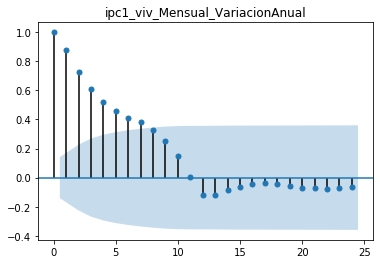

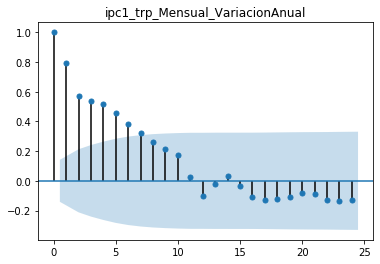

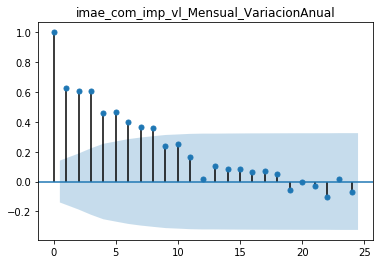

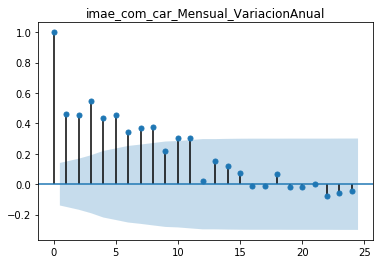

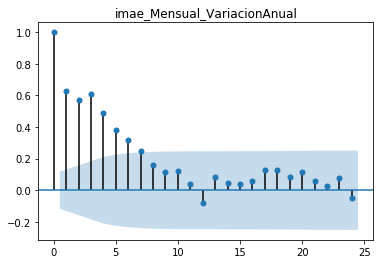

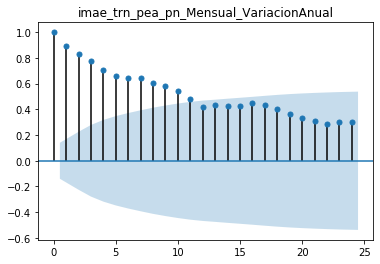

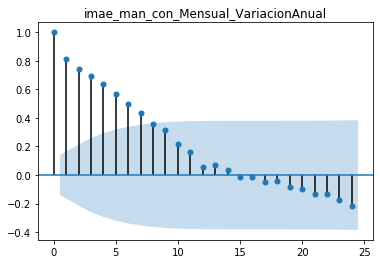

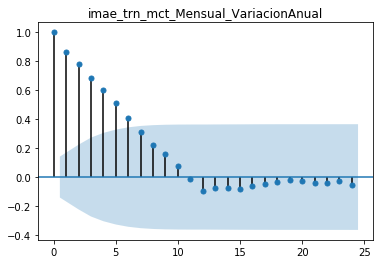

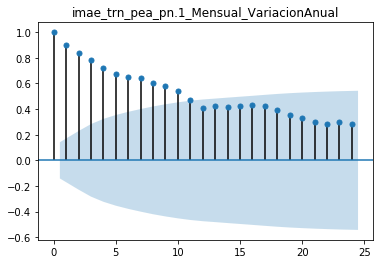

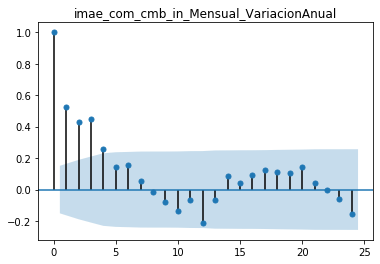

In [6]:
for x in [y for y in bd_mensual_t.columns if ('Mensual_VariacionAnual' in y)]:
    try:
        sm.graphics.tsa.plot_acf(bd_mensual_t[x].dropna(), lags=24, title = x)
        plt.plot()
    except:
        print('Variable ' + x + ' sin datos suficientes')
        pass

# Base de datos Trimestrales

###### Estadísticos Descriptivos

In [7]:
display(bd_trimestral_t[[x for x in bd_trimestral_t.columns if 'Nivel' in x]].describe())
display(bd_trimestral_t[[x for x in bd_trimestral_t.columns if 'Logs' in x]].describe())
display(bd_trimestral_t[[x for x in bd_trimestral_t.columns if 'Trimestre_VariacionAnual' in x]].describe())

,pbif_1_Nivel,pbif_2_Nivel,pbif_Nivel
count,71.000000,52.000000,96.000000
mean,3889.006657,8067.082646,6016.156212
std,1360.339137,1846.602480,2642.074243
min,2219.385349,4958.985000,2697.862642
25%,2820.003820,6123.013250,3558.553905
50%,3361.652753,8187.931500,5661.424000
75%,4830.960917,9663.765250,8368.906000
max,7089.584024,11221.451143,11221.451143


,pbif_1_Logs,pbif_2_Logs,pbif_Logs
count,71.000000,52.000000,96.000000
mean,8.210091,8.968651,8.605478
std,0.330609,0.237092,0.443970
min,7.704986,8.508956,7.900215
25%,7.944491,8.719797,8.177107
50%,8.120188,9.010364,8.641307
75%,8.482781,9.176052,9.032278
max,8.866382,9.325583,9.325583


,pbif_1_Trimestre_VariacionAnual,pbif_2_Trimestre_VariacionAnual,pbif_Trimestre_VariacionAnual
count,67.000000,48.000000,92.000000
mean,0.066886,0.061598,0.060691
std,0.035688,0.032299,0.036527
min,-0.006853,0.001394,-0.006853
25%,0.044427,0.041743,0.038746
50%,0.072630,0.054079,0.055481
75%,0.093443,0.081646,0.076897
max,0.130929,0.135695,0.180426


##### Autocorrelaciones

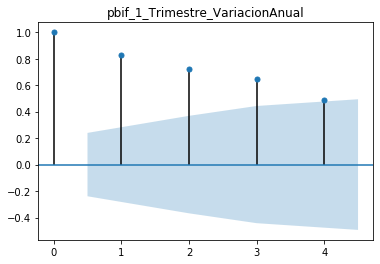

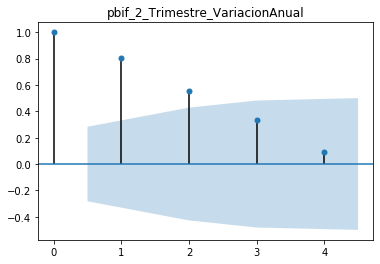

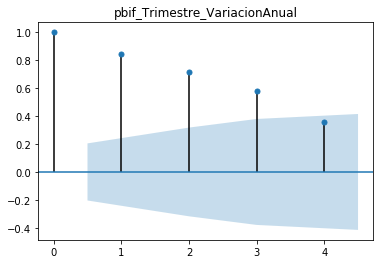

In [8]:
for x in [y for y in bd_trimestral_t.columns if ('Trimestre_VariacionAnual' in y)]:
    try:
        sm.graphics.tsa.plot_acf(bd_trimestral_t[x].dropna(), lags=4, title = x)
    except:
        print('Variable ' + x + ' sin datos suficientes')
        pass

# Base de datos Anuales

In [9]:
bd_anual_t.describe()

,bd_Nivel,bd_Logs,bd_VariacionAnual
count,0.0,0.0,0.0
mean,NaN,NaN,NaN
std,NaN,NaN,NaN
min,NaN,NaN,NaN
25%,NaN,NaN,NaN
50%,NaN,NaN,NaN
75%,NaN,NaN,NaN
max,NaN,NaN,NaN


# Base consolidada

In [10]:
display(bd_all.describe())
display(bd_all.info())

,ipc1_viv_Nivel,ipc1_viv_12Meses,ipc1_viv_Logs,ipc1_viv_Trimestre,ipc1_viv_Trimestre_VariacionAnual,ipc1_viv_VariacionMensual,ipc1_viv_Mensual_VariacionAnual,ipc1_viv_12Meses_VariacionAnual,ipc1_trp_Nivel,ipc1_trp_12Meses,...,pbif_2_12Meses_VariacionAnual,pbif_Nivel,pbif_12Meses,pbif_Logs,pbif_VariacionTrimestral,pbif_Trimestre_VariacionAnual,pbif_12Meses_VariacionAnual,bd_Nivel,bd_Logs,bd_VariacionAnual
count,204.000000,193.000000,204.000000,202.000000,190.000000,203.000000,192.000000,181.000000,204.000000,193.000000,...,45.000000,96.000000,93.000000,96.000000,95.000000,92.000000,89.000000,0.0,0.0,0.0
mean,94.003168,1130.151704,4.539882,94.036051,0.015908,0.001319,0.015812,0.016685,87.098016,1048.867753,...,0.060276,6016.156212,23953.441583,8.605478,0.015529,0.060691,0.061071,NaN,NaN,NaN
std,7.662023,86.837895,0.084107,7.572304,0.033716,0.011332,0.035571,0.028187,16.586782,191.238740,...,0.026891,2642.074243,10283.489197,0.443970,0.028846,0.036527,0.033479,NaN,NaN,NaN
min,78.848275,955.538145,4.367525,79.030253,-0.096169,-0.060096,-0.111557,-0.073436,59.178554,715.133606,...,0.012006,2697.862642,11331.846029,7.900215,-0.078072,-0.006853,0.005742,NaN,NaN,NaN
25%,88.675063,1081.570601,4.484979,88.870039,0.000061,-0.000781,-0.001300,0.002259,71.002381,883.816250,...,0.045319,3558.553905,14084.377374,8.177107,0.006761,0.038746,0.034825,NaN,NaN,NaN
50%,96.318120,1143.338982,4.567656,96.227132,0.018444,0.000925,0.019252,0.018145,95.303614,1128.432821,...,0.054975,5661.424000,22606.638000,8.641307,0.019884,0.055481,0.057351,NaN,NaN,NaN
75%,101.000000,1211.228493,4.615121,100.966667,0.037987,0.003914,0.037557,0.041061,101.719996,1221.858018,...,0.076449,8368.906000,33124.369000,9.032278,0.031432,0.076897,0.076449,NaN,NaN,NaN
max,105.300000,1229.897285,4.656813,104.009498,0.082029,0.051528,0.089868,0.067902,108.349900,1276.928100,...,0.117405,11221.451143,43340.282612,9.325583,0.083407,0.180426,0.149653,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 294 entries, 1996-01-01 to 2020-06-01
Columns: 101 entries, ipc1_viv_Nivel to bd_VariacionAnual
dtypes: float64(101)
memory usage: 234.3 KB


None

# Correlaciones

Cálculo de las correlaciones entre las variables de la base mensual con la variable seleccionada, como punto de partida para la elección de las variables usadas para realizar las proyección en los siguientes pasos. \
Se usa el IMAE de referencia.

In [11]:
VariablesPBI = ['imae_trn_pea_pn_Mensual_VariacionAnual'
               ]

In [12]:
VariablesExogenas = list(set([x for x in bd_all.columns if 'Mensual_VariacionAnual' in x]) - set(VariablesPBI))

In [13]:
var_sel = {}
correl_df = pd.DataFrame(index = VariablesExogenas)
for x in VariablesPBI:
    VariablesExogenasObservaciones = [z for z in VariablesExogenas if bd_all[z].count()/bd_all[x].count()>0.5]
    correl_df[x] = bd_all[VariablesExogenasObservaciones + [x]].corr()[x][:].drop(x)
    correl_df = correl_df.sort_values(x, ascending = False)
    aux_sel = correl_df.index[np.abs(correl_df[x]) > 0.5].tolist()
    if len(aux_sel) == 0:
        aux_sel = [correl_df[x].idxmax()]
    var_sel[x] = aux_sel

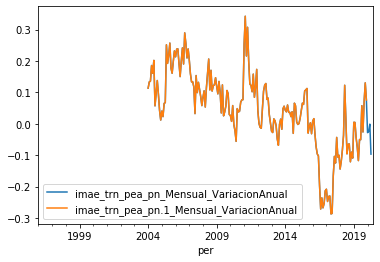

In [14]:
bd_all[VariablesPBI + var_sel[VariablesPBI[0]]].plot()

In [15]:
correl_df = correl_df.dropna(how='all')
correl_df = correl_df.sort_values(VariablesPBI, ascending = False)
correl_df

,imae_trn_pea_pn_Mensual_VariacionAnual
imae_trn_pea_pn.1_Mensual_VariacionAnual,1.000000
ipc1_trp_Mensual_VariacionAnual,0.420682
imae_com_car_Mensual_VariacionAnual,0.397843
imae_trn_mct_Mensual_VariacionAnual,0.329219
imae_Mensual_VariacionAnual,0.321485
imae_com_imp_vl_Mensual_VariacionAnual,0.304791
imae_com_cmb_in_Mensual_VariacionAnual,0.283021
imae_man_con_Mensual_VariacionAnual,0.209560
ipc1_viv_Mensual_VariacionAnual,0.193494


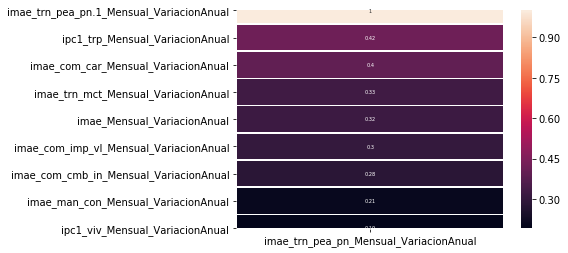

In [16]:
sns.heatmap(np.abs(correl_df).sort_values(VariablesPBI, ascending = False).head(30),annot=True,linewidths=.5, annot_kws={"size": 5})

In [17]:
bd_all.to_excel(rutaDestino + "bd_all_estimacion.xlsx",sheet_name='bd_all_kalman') 